# Within Sum of Squares and IMD analysis

This notebook analyses resulting clusters using WSS and a relationship between clusters and the IMD.

The `darribas/gds_py:6.1` Docker container was used to create a computational environment.

In [ ]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd

In [ ]:
data = pd.read_csv('sentinel_gb_encoder_map_3_20210317_smoothed.csv', index_col=0)
labels = pd.read_csv("sentinel_gb_encoder_map_3_20210317_smoothed_10k_labels.csv", index_col=0,)

In [ ]:
centroids = data.groupby(labels.cluster.values).mean()

In [ ]:
squared_error = pd.concat([(data.loc[labels.cluster == i] - centroids.loc[i]) ** 2 for i in range(7)]).sort_index()

In [ ]:
squared_error_sum = squared_error.sum(axis=1)

In [ ]:
mean_squared_error = squared_error_sum.groupby(labels.cluster.values).mean()
mean_squared_error

0    1.239086
1    0.256577
2    0.359320
3    1.427487
4    0.852287
5    0.220248
6    0.322644
dtype: float64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})

In [ ]:
labels["error"] = squared_error_sum

In [ ]:
obs_counts = labels.cluster.value_counts()

In [ ]:
cluster_names = "ABCDEFG"

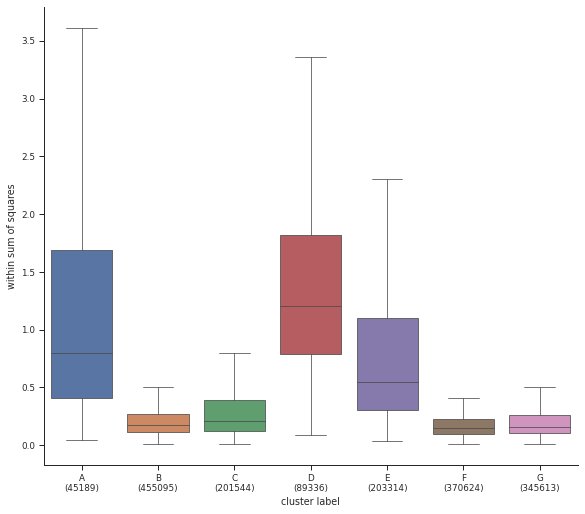

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

sns.boxplot(x="cluster", y="error", hue='cluster', dodge=False, data=labels, showfliers=False, linewidth=.75, ax=ax)
plt.legend([],[], frameon=False)
sns.despine()
ax.set_ylabel("within sum of squares")
ax.set_xlabel("cluster label")

x_labels = [cluster_names[i] + f"\n({obs_counts[i]})" for i, item in enumerate(ax.get_xticklabels())]
ax.set_xticklabels(x_labels)

plt.savefig(f"figs/squared_error_sum.pdf", dpi=150)

In [ ]:
sector = labels.PCDS.str.split(" ").apply(lambda x: x[0])

In [ ]:
sector_data = squared_error_sum.groupby(sector).describe()
sector_data

,count,mean,std,min,25%,50%,75%,max
PCDS,,,,,,,,
AB10,675.0,0.201004,0.388954,0.023556,0.081900,0.123259,0.183171,3.247271
AB11,642.0,0.260221,0.372207,0.045780,0.132138,0.186119,0.251538,3.485213
AB12,797.0,0.597891,0.831370,0.041540,0.150103,0.260930,0.607934,4.599404
AB13,86.0,0.627698,0.579101,0.059035,0.268618,0.452741,0.683968,3.254864
AB14,142.0,0.443040,0.710041,0.051355,0.105250,0.153745,0.313562,3.430795
...,...,...,...,...,...,...,...,...
YO8,1294.0,0.504283,0.715602,0.037709,0.117974,0.208944,0.527891,6.540000
YO90,10.0,0.574485,0.355448,0.184361,0.184361,0.706791,0.898455,0.898455
ZE1,327.0,0.576843,0.690216,0.061873,0.255441,0.325530,0.557516,4.791093


In [ ]:
sector_data.to_csv("../urbangrammar_samba/postcode_classification/data/fit_per_sector.csv")

## IMD

In [ ]:
onspd = pd.read_csv("../urbangrammar_samba/postcode_classification/data/ONSPD_202102_utm.csv", index_col=0)

In [ ]:
onspd.columns

Index(['pcds', 'usertype', 'oseast1m', 'osnrth1m', 'osgrdind', 'lat', 'long',
       'ctry', 'current', 'dointr', 'doterm', 'doupdt', 'oslaua', 'osward',
       'oscty', 'pcon', 'oa11', 'lsoa11', 'msoa11', 'parish', 'imd',
       'UTM_ZONE', 'UTM_X', 'UTM_Y'],
      dtype='object')

In [ ]:
geom = gpd.read_parquet("postcodes_clustered.pq")
geom

,PCDS,geometry,cluster,error
0,AB10 1AB,POINT (394235.441 806530.784),0,0.562764
1,AB10 1AF,POINT (394181.440 806430.784),0,0.607934
2,AB10 1AG,POINT (394230.026 806469.006),2,0.535169
3,AB10 1AH,POINT (394371.467 806360.721),2,0.189136
4,AB10 1AL,POINT (394296.014 806581.022),0,0.615652
...,...,...,...,...
1710710,ZE3 9JU,POINT (438872.230 1111806.351),4,0.958750
1710711,ZE3 9JW,POINT (438975.215 1110037.332),3,1.116277
1710712,ZE3 9JX,POINT (438872.255 1110218.355),3,1.515320
1710713,ZE3 9JY,POINT (438498.246 1112028.331),4,1.611978


In [ ]:
imd = geom.drop(columns="error").merge(onspd[["pcds", "imd"]], left_on="PCDS", right_on="pcds", how="inner")

In [ ]:
imd['cluster'] = imd.cluster.replace({0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"})

In [ ]:
imd.imd = imd.imd.astype(int)

In [ ]:
imd['cluster'] = pd.Categorical(imd.cluster, ordered=True)

In [ ]:
imd

,PCDS,geometry,cluster,pcds,imd
0,AB10 1AB,POINT (394235.441 806530.784),A,AB10 1AB,4907
1,AB10 1AF,POINT (394181.440 806430.784),A,AB10 1AF,4907
2,AB10 1AG,POINT (394230.026 806469.006),C,AB10 1AG,4907
3,AB10 1AH,POINT (394371.467 806360.721),C,AB10 1AH,3290
4,AB10 1AL,POINT (394296.014 806581.022),A,AB10 1AL,4907
...,...,...,...,...,...
1710710,ZE3 9JU,POINT (438872.230 1111806.351),E,ZE3 9JU,4187
1710711,ZE3 9JW,POINT (438975.215 1110037.332),D,ZE3 9JW,4187
1710712,ZE3 9JX,POINT (438872.255 1110218.355),D,ZE3 9JX,4187
1710713,ZE3 9JY,POINT (438498.246 1112028.331),E,ZE3 9JY,4187


In [ ]:
england = gpd.read_file("../urbangrammar_samba/postcode_classification/data/Regions_(December_2017)_Boundaries.geojson")

In [ ]:
england = england.to_crs(27700).unary_union

In [ ]:
imd_england = imd.iloc[imd.sindex.query(england, "contains")]
imd_england

,PCDS,geometry,cluster,pcds,imd
1554107,TR21 0HE,POINT (90785.972 10170.990),D,TR21 0HE,22165
1554147,TR21 0NH,POINT (91410.724 10209.391),E,TR21 0NH,22165
1554148,TR21 0NJ,POINT (91450.760 10239.418),E,TR21 0NJ,22165
1554161,TR21 0PA,POINT (91339.761 10262.423),E,TR21 0PA,22165
1554149,TR21 0NL,POINT (91529.731 10309.366),E,TR21 0NL,22165
...,...,...,...,...,...
1559379,TS10 3PT,POINT (461759.026 523988.577),G,TS10 3PT,18345
1559378,TS10 3PS,POINT (461864.991 524001.589),G,TS10 3PS,18345
1559375,TS10 3PP,POINT (461898.033 524032.649),G,TS10 3PP,18345
1559363,TS10 3NW,POINT (461816.001 524074.607),G,TS10 3NW,18345


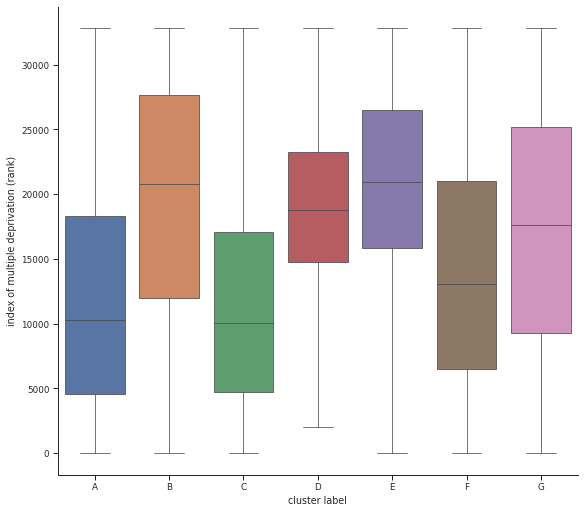

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

sns.boxplot(x="cluster", y="imd", hue='cluster', dodge=False, data=imd_england, showfliers=False, linewidth=.75, ax=ax)
plt.legend([],[], frameon=False)
sns.despine()

ax.set_ylabel("index of multiple deprivation (rank)")
ax.set_xlabel("cluster label")

plt.savefig(f"figs/imd_rank.pdf", dpi=150)